In [1]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import random

In [2]:
# Load the DataFrame from the CSV file
df = pd.read_csv('grad_cam_RVL_dataset.csv')

In [10]:
# Load CNN model
model = models.efficientnet_b0()
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 16)
model.load_state_dict(torch.load('model_CNN.pth'))
model.eval()

# Preprocess the image
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
        transforms.Resize((224, 224)),  # Resize to the input size of the model
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
    ])
    image = Image.open(image_path)  
    image = preprocess(image).unsqueeze(0)  
    return image
#Apply Grad CAM
def grad_cam(model, image_tensor, target_layer_name):
    gradients = []

    def save_gradient(grad):
        gradients.append(grad)

    target_layer = dict([*model.named_modules()])[target_layer_name]
    activations = []

    def save_activation(module, input, output):
        activations.append(output)
        output.register_hook(save_gradient)

    handle = target_layer.register_forward_hook(save_activation)

    # Move image tensor to the same device as the model
    image_tensor = image_tensor.to(next(model.parameters()).device)

    # Forward pass
    output = model(image_tensor)
    pred_class = output.argmax(dim=1).item()
    
    # Backward pass
    model.zero_grad()
    output[:, pred_class].backward()

    handle.remove()  # Remove the forward hook

    gradients = gradients[0].cpu().data.numpy()
    activations = activations[0].cpu().data.numpy()

    return gradients, activations, pred_class
def generate_heatmap(gradients, activations):
    weights = np.mean(gradients, axis=(2, 3))
    cam = np.zeros(activations.shape[2:], dtype=np.float32)

    for i, w in enumerate(weights[0]):
        cam += w * activations[0, i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam - cam.min()
    cam = cam / cam.max()
    return cam
def superimpose_heatmap(image_tensor, heatmap):
    image = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())  # Normalize image
    image = np.uint8(255 * image)
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + image
    return superimposed_img


In [11]:

image_dir = 'C:/Users/HP/Desktop/Projet/CODE/grad_cam_RVL_dataset/'

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Select a random image file
random_image_file = random.choice(image_files)

# Get the full path to the random image file
random_image_path = os.path.join(image_dir, random_image_file)

image_label = df.loc[df['Image'] == random_image_file, 'Label'].values[0]

# Load and display the image
image = Image.open(random_image_path)
image.show()
# Print the label of the random image
#print(f'The full path of the selected image is: {random_image_path}')
# Preprocess image
image_tensor = preprocess_image(random_image_path)
#print(f'Image tensor shape: {image_tensor.shape}')

In [12]:
 # Apply Grad-CAM
target_layer_name = 'features.8'
gradients, activations, pred_class = apply_grad_cam(model, image_tensor, target_layer_name)
#print(f'Gradients shape: {gradients.shape}')
#print(f'Activations shape: {activations.shape}')
print(f'Predicted class: {pred_class}')
print(f'True class: {image_label}')


Predicted class: 0
True class: 0


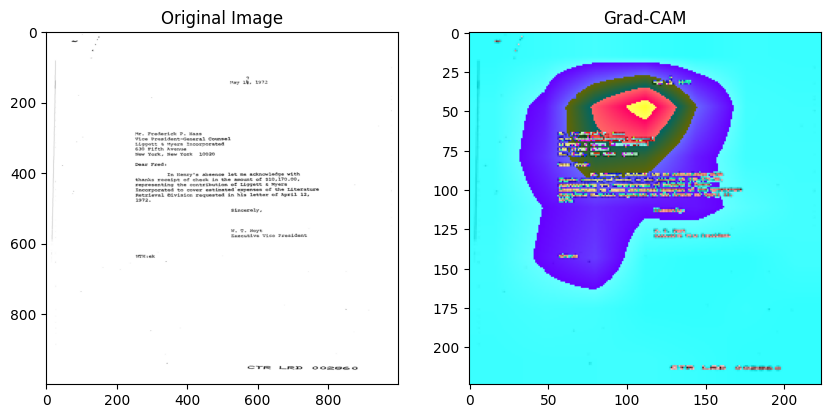

In [13]:

# Generate and superimpose heatmap
heatmap = generate_heatmap(gradients, activations)
superimposed_img = superimpose_heatmap(image_tensor, heatmap)
    
# Plot the result
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(random_image_path), cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img.astype(np.uint8))
plt.title('Grad-CAM')

plt.show()